# Creating calibrated size distributions using FAAM data (PCASP and CDP)
**Erin Raif, 17 February 2023** - code version 1.

This code is inspired by previous work by **Alberto Sanchez-Marroquin** and **Sarah Barr**. 

**TL;DR**: This notebook will create particle size distributions for PCASP and CDP data from the FAAM campaign.

**TL;DR, but longer**: The PCASP probe nominally measures aerosols in the size range 0.1-3 micron. The CDP probe nominally measures cloud droplets in the size range 2-50 micron, but can be applied to aerosol by deriving particle concentrations from raw counts using a refractive index that is appropriate for aerosol. These can be used to create aerosol size distributions in the accumulation and coarse mode size ranges.

# Contents
*(note the contents formatting sometimes is a bit funky outside VSCode)*
1) [Introduction](#intro):
     - [Notebook purpose and contents](#what-does-this-notebook-actually-do)
     - [Pre-requisites](#pre-requisites-using-the-rosenberg-code)
     - [Plotting keyword arguments](#keyword-arguments-for-more-custom-plotting)
2) [Generating scattering data using MieConScat](#generating-scattering-data-using-mieconscat)
3) [Generating channel diameter (and area/volume) data using CStoDConverter](#creating-channel-diameter-and-areavolume-data-using-cstodconverter)
4) [Reading and processing aircraft data](#processing-aircraft-data)
5) [Calculating logarithmic particle size distribution data and errors](#calculating-particle-size-distribution-data-and-errors)
     - [Merging particular channels of PCASP data](#merging-bins-for-the-pcasp-data)
6) [Plotting logarithmic particle size distributions](#plotting-logarithmic-particle-size-distributions)
     - [Example - Variation of  size distributions with refractive index](#example---variation-of-distributions-with-refractive-index---flight-c274-filter-run-3)
     - [Example - Total PCASP concentration and data flag](#example---plot-total-pcasp-number-concentration-over-time---flight-c274-run-3)
     - [Example - Comparing CDP data with different humidity caps](#example---comparing-cdp-data-with-different-humidity-caps)
     - [Example - Combining PCASP and CDP data to get a total number/size/volume concentration](#example---combining-pcasp-and-cdp-data-to-get-a-total-numbersizevolume-concentration)
7) [Optional: INP data reading and plotting](#optional-reading-input-filter-data-and-metadata)


# Introductory information
<a id='intro'></a>
## How do the probes work and how does calibration work?
The probes each have thirty channels across three gain stages. Particles are counted when they pass through a laser beam, and the fall in transmitted radiation is associated with a particular size bin. These size bins have nominal particle diamater ranges attached to them. However, the effects of Mie Scattering mean that the effective diameter measured by each channel will vary according to the refractive index of the particle.

Calibration is performed by passing reference beads through the probes and acquiring counting statistics for each bin. Using the software **MieConScat**, particle scattering cross-sections for one or more refractive indices relevant to the aerosol sample can be obtained. These can be passed through the **CStoDConverter** program to get channel diameters for the particle-size distributions.

For details of the calibration process, see Rosenberg, et al. (2012). *Particle sizing calibration with refractive index correction for light scattering optical particle counters and impacts upon PCASP and CDP data collected during the Fennec campaign*. Atmos. Meas. Tech. **5**:5 doi:10.5194/amt-5-1147-2012 (from hereon in, PR12)

The above reference also contains details of the **MieConScat** program and the **CStoDConverter** program.

For mathematical details of Mie Scattering, see K. N. Liou (2002). *Introduction to Atmospheric Radiation* 2nd ed. Elsevier Science: London. **Chapters 5.2 and 5.3.**


## What does this notebook actually do?
This notebook takes calibrated size channels as calculated by Phil Rosenberg's code and creates aerosol-size distributions. $x$-errors are derived using the Rosenberg process. $y$-errors are derived from counting statistics.
$\mathrm{d}N/\mathrm{d}\log{(D)}$, $\mathrm{d}S/\mathrm{d}\log{(D)}$ and $\mathrm{d}V/\mathrm{d}\log{(D)}$ are all calculated and orthogonal distance regression is used to fit a double-moment lognormal distribution to these. The fitting process is deliberately designed to be semi-automatic to avoid the user pressing on with inappropriate starting guesses for the solver (explained later on). The user can generate total surface area values between given bounds that match channel width.

Some choices in data processing are made according to Sanchez-Marroquin, 2019 (SM19 from hereon in), which you should definitely read!

Sanchez-Marroquin et al. (2019). *Characterisation of the filter inlet system on the FAAM BAe-146 research aircraft and its use for size-resolved aerosol composition measurements*. Atmos. Meas. Tech. **12**:11. doi:10.5194/amt-12-5741-2019

## Pre-requisites using the Rosenberg code
- You should have downloaded [**MieConScat**](https://sourceforge.net/projects/mieconscat/) and [**CStoDConverter**](https://sourceforge.net/projects/cstodconverter/) already. *(click links to download from Sourceforge)*
- You will need the calibration files from **FAAM**, an example version of this for *ACAO* is included in the GitHub repo.
  - To get this, you will need to talk to **Graeme Nott** at FAAM. Currently, PCASP calibrations are available for DCMEX and M-PHASE and CDP calibrations are available for DCMEX. (correct as of 16/02/23)
  - You will need specifically to ask for "the CSVs containing calibration data that is used with Phil Rosenberg's CStoD code". Feel free to refer to what he has already given me.
  - There is some calibration data in the calibration netCDF files on CEDA, including scattering cross-sections for the channels. However, there is not enough data to reproduce the CSVs that are used with CS_to_D_converter. 

### Generation of calibration files using this notebook
This notebook generates scattering information by interacting with **MieConScat** and **CStoDConverter** in the command line. I have only tested this on Windows, I can't promise this works on Unix systems including Jasmin so you may wish to generate these offline.

## Pre-requisites for the notebook
- Imports required included in the cell below. Note that the version of xarray you have installed currently must be exactly version 2022.6.0 - a future version of this code may negate this requirement.
  - If you have a different xarray version, you should create a new conda virtual environment with the correct version of xarray. Use the command `conda install -c conda-forge xarray=2022.6.0` in the Anaconda Prompt terminal when your new environment is activated.
- There is no specific file structure needed for flight data. Cells are included for DIY generation of lists of inputs that can be passed to functions in your own loops.
- To analyse a particular flight, you should use the full (not 1 Hz) versions of both the core FAAM data and the core cloud FAAM data. Time slices should come from filters metadata
- Running this notebook in **VSCode** is recommended but not essential. VSCode allows you to see tooltips for all the functions defined in this notebook, making further coding using these functions much easier. VSCode also has debugging and live error checking in a much more accessible way than in-browser notebooks.

### Optional pre-requisites
- If you have background-subtracted $n_{\mathrm{INP}}$ data, this can be plotted alongside the data for a useful quick-look and can be used to derive $n_{s}$ values.
- This notebook assumes that $n_{\mathrm{INP}}$ data is in the format of a CSV file where each filter has a custom ID (*`filterID`*). Columns in the CSV have the concentration of INP at integer degree temperature intervals - these are named *`filterID`*`_NT`. The associated errors are found in columns in the CSV with name *`filterID`*`_err`.
- A separate metadata CSV file for information about the INP runs

## Keyword arguments for more flexible plotting
This notebook makes use of python's [`**kwargs`](https://www.geeksforgeeks.org/args-kwargs-python/) (keyword arguments) feature to pass more information to the plotting functions that have been made. This lets the user optionally pass an unlimited number of arguments to a function to increase the functionality of a function. These must be passed after the usual arguments. A list of those used in this notebook is below. Obviously if you want to customise your plot significantly more than what's below, you'll need to make your own functions/adapt mine.
Pass kwargs to functions using a dictionary (as described in the link at the start of this paragraph).

| `kwarg`                  | Format                               | Adjustment                                    |
|--------------------------|--------------------------------------|-----------------------------------------------|
| `xlim`                   | `[lower_limit,upper_limit]` (floats) | Change the x-axis limits                      |
| `ylim`                   | `[lower_limit,upper_limit]` (floats) | Change the y-axis limits                      |
| `xlabel`                 | string                               | Change the x-axis label                       |
| `ylabel`                 | string                               | Change the y-axis label                       |
| matplotlib plot kwargs   | various (NOTE - check plot function docstring to check compatibility - works with most but not all functions) | Make changes to the specific plot function, e.g. ax.errorbar() or ax.scatter(). Kwargs are the kwargs compatible with matplotlib, you should check their documentation for full functionality. Note that this will only affect plot-level parameters such as plot linewidth, and trying to change axes-level parameters such as grid visibility will not work (and probably break it!) |

An example of using the axis limit and label kwargs is in [Section 7](#plotting-inp-concentrations). An example of the use of matplotlib kwargs is in [Section 6](#plotting-logarithmic-particle-size-distributions).


In [1]:
# Standard Library
import os
import re  # regex (not sure why)
from glob import glob
import datetime as dt
#import cmath

# Others
import pandas as pd
import numpy as np
import xarray as xr # Version 2022.6.0 is the only version where this works - maybe there's a 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib as mpl

In [2]:
"""
If you are using VS Code, run this cell for interactive plots. Only do this if you
are NOT generating large numbers of plots/are closing plots as you go as it uses more memory.
"""
%matplotlib widget

In [ ]:
"""
Or if you are using the standard Jupyter notebook interface, run this cell for interactive plots.
Only do this if you are NOT generating large numbers of plots/are closing plots as you go as it uses more memory.
"""
#%matplotlib notebook

In [1]:
def kwarg_handling(ax, axes_defaults, user_kwargs, ignore_lims=False):
    """
    ax: matplotlib axes
        Axes to plot on
    axes_defaults: dict
        Dictionary of default kwargs for the plot
    user_kwargs: dict
        User-defined kwarg dictionary for the plot
    ignore_lims: bool (default False)
        Ignore limit kwargs (needed when limits are not appropriate to be pre-chosen)
    """
    if not ignore_lims:
        if 'xlim' in user_kwargs:
            ax.set_xlim(user_kwargs['xlim'])   
        else:
            ax.set_xlim(axes_defaults['xlim'])
        if 'ylim' in user_kwargs:
            ax.set_ylim(user_kwargs['ylim'])   
        else:
            ax.set_ylim(axes_defaults['ylim'])
    if 'xlabel' in user_kwargs:
        ax.set_xlabel(user_kwargs['xlabel'])
    else:
        ax.set_xlabel(axes_defaults['xlabel'])
    if 'ylabel' in user_kwargs:
        ax.set_ylabel(user_kwargs['ylabel'])
    else:
        ax.set_ylabel(axes_defaults['ylabel'])
    for kw in ('xlim', 'ylim', 'xlabel', 'ylabel'):
        user_kwargs.pop(kw, None)
    return ax, user_kwargs
    

# Generating scattering data using MieConScat
Using the MieConScat software, you can generated tables of scattering data for particular refractive index values.
While you can generate tables for multiple refractive indices, it is probably easiest to generate individual tables for refractive indices and access them using filenames as the files can get large quickly. This is the choice that I have made here.

**Important - I have chosen a filename convention and file location of the form `.\scattering_files\scattering_INSTRUMENT_REAL+-IMAGINARYj.csv`** (e.g. `scattering_PCASP_1.58-0.01j.csv`). If you choose another convention, you will need to re-write the code here.

You will need to use particular values for the laser wavelengths and diameters you wish to investigate (in microns), and scattering angles of the probe. Defaults for each instrument are contained in dictionaries below, but of course you can edit if you feel the need.
|Instrument|Diameter range|Diameter resolution|Primary scattering angle|Secondary scattering angle|Wavelength|
|----------|--------------|-------------------|------------------------|--------------------------|----------|
|PCASP     |0.05-8        |0.001              |35-120 degrees          |60-145 degrees            |0.6328    |
|CDP       |1-100         |0.1                |1.7-14 degrees          |None                      |0.658     |

Note that in various documentation, the CDP angles are given as 4-12 degrees. This is information is abuot ten years old and currently it looks at a different range.

In [4]:
# MieConScat Program location - adjust these for your own computer
mcs_loc = r'.\MieConScat\MieConTabGenConsole.exe'
# CS_to_DConverter Program location - adjust these for your own computer
cstod_loc = r'.\CStoDConverter_1.2.10\cstodconverterconsole.exe'

In [5]:
# Custom dictionaries should have the same format
pcasp_scattering_inputs = {
    'name'         : 'PCASP',
    'min_diameter' : 0.05,
    'max_diameter' : 8,
    'diameter_res' : 0.001,
    'min_primary'  : 35,
    'max_primary'  : 120,
    'min_secondary': 60,
    'max_secondary': 145,
    'wavelength'   : 0.6328
    }
cdp_scattering_inputs = {
    'name'         : 'CDP',
    'min_diameter' : 1,
    'max_diameter' : 100,
    'diameter_res' : 0.1,
    'min_primary'  : 1.7,
    'max_primary'  : 14,
    'min_secondary': None,
    'max_secondary': None,
    'wavelength'   : 0.658
    }


In [6]:
def add_item_to_command(command, item, value):
    try:
        command = command + ' -' + item + ' ' + str(value)
        return command
    except:
        print(item + ' not in input dictionary')
        exit

def generate_scattering_table(ri, folder, input_dict, silent=False):
    """Generate Mie Scattering data interacting with the MieConScat program.

    Using default values for the PCASP or CDP probe, use Phil Rosenberg's code to generate Mie
    Scattering data for a particular refractive index. You can also specify a 'Custom' instrument
    with a custom dictionary of instrument parameters.

    Parameters
    ----------
    ri: complex number
        Complex number in the standard Python form RE+IMj (e.g. 1.58-0.03j).
    folder: string
        string for the folder location where the files will be output. Should not end in \\
    custom_input: dict (default None)
        Dictionary of input parameters in the format of the defaults for CDP/PCASP
    silent: bool (default False)
        silence the commands you're passing to the CL (not recommended)

    Returns
    -------
    none
    """
    try:
        command = mcs_loc + ' -wav ' + str(input_dict['wavelength'])
    except:
        print('Wavelength not in input dictionary')
    
    # Build command to run the scattering program.
    command = add_item_to_command(command, 'dmin', input_dict['min_diameter'])
    command = add_item_to_command(command, 'dmax', input_dict['max_diameter'])
    command = add_item_to_command(command, 'dint', input_dict['diameter_res'])
    command = add_item_to_command(command, 'rerimin', ri.real)
    command = add_item_to_command(command, 'imrimin', ri.imag)
    command = add_item_to_command(command, 'ang1min', input_dict['min_primary'])
    command = add_item_to_command(command, 'ang1max', input_dict['max_primary'])
    if input_dict['min_secondary'] != None:
        command = add_item_to_command(command, 'ang2min', input_dict['min_secondary'])
        command = add_item_to_command(command, 'ang2max', input_dict['max_secondary'])
    filename = 'scattering_' + input_dict['name'] + '_' + str(ri)[1:-1] + '.csv'
    command = command + ' ' + folder + '\\' + filename
    if silent == False:
        print(command)
    os.system(command)
    return filename

In [7]:
mie_scattering_folder = '.\\scattering_files'

In [8]:
# List of refractive indices to test - you may wish to generate this programmatically
# These refractive indices are those tested in SM19 and a good starting point for INP filter data.
refractive_indices = [
    1.56+0j, 1.5+0j, 1.6+0j, 1.7+0j,
    1.56+0.001j,1.56+0.003j,1.56+0.006j,1.56+0.01j
    ]

In [157]:
# Note that with the default settings this takes about 40s to create 16 calibrations
for ri in refractive_indices:
    pcasp_mie = generate_scattering_table(ri, mie_scattering_folder, pcasp_scattering_inputs)
    cdp_mie = generate_scattering_table(ri, mie_scattering_folder, cdp_scattering_inputs)

.\MieConScat\MieConTabGenConsole.exe -wav 0.6328 -dmin 0.05 -dmax 8 -dint 0.001 -rerimin 1.56 -imrimin 0.0 -ang1min 35 -ang1max 120 -ang2min 60 -ang2max 145 .\scattering_files\scattering_PCASP_1.56+0j.csv
.\MieConScat\MieConTabGenConsole.exe -wav 0.658 -dmin 1 -dmax 100 -dint 0.1 -rerimin 1.56 -imrimin 0.0 -ang1min 1.7 -ang1max 14 .\scattering_files\scattering_CDP_1.56+0j.csv
.\MieConScat\MieConTabGenConsole.exe -wav 0.6328 -dmin 0.05 -dmax 8 -dint 0.001 -rerimin 1.5 -imrimin 0.0 -ang1min 35 -ang1max 120 -ang2min 60 -ang2max 145 .\scattering_files\scattering_PCASP_1.5+0j.csv
.\MieConScat\MieConTabGenConsole.exe -wav 0.658 -dmin 1 -dmax 100 -dint 0.1 -rerimin 1.5 -imrimin 0.0 -ang1min 1.7 -ang1max 14 .\scattering_files\scattering_CDP_1.5+0j.csv
.\MieConScat\MieConTabGenConsole.exe -wav 0.6328 -dmin 0.05 -dmax 8 -dint 0.001 -rerimin 1.6 -imrimin 0.0 -ang1min 35 -ang1max 120 -ang2min 60 -ang2max 145 .\scattering_files\scattering_PCASP_1.6+0j.csv
.\MieConScat\MieConTabGenConsole.exe -wav 0

## Generating higher-order cross-section data
Once you have generated scattering tables using MieConScat, you must then use the calibration file provided by FAAM to generate channel diameters. However, Rosenberg advises:
- *Because of the nonlinear non-monotonic relationship between scattering cross section and diameter, the calculation of higher order properties, such as particle area or volume or log of diameter, from the estimated diameters should be approached with caution* ... *The following method is therefore recommended for calculating higher order properties. Simply replace the diameter column in the scattering data file with the quantity of interest.*

This allows you to generate scattering data for the higher-order properties of surface area and volume. Using these later on means the channels become surface area and volume bins but allows errors to be propagated.

In [9]:
def create_higher_order_scatter_data(folder,csv_name):
    """Create surface area and particle volume channel cross-section data.

    Parameters
    ----------
    folder: string
        name of the folder containing scattering data
    csv_name: string
        name of the diameter CSV to process
    """

    # Read in data to pandas df and create area and volume columns
    scat_data = pd.read_csv(os.path.join(folder,csv_name), header=5)
    ri_str = list(scat_data.columns)[1]
    scat_data['area'] = np.pi * scat_data['Diameter']**2 # microns^2
    scat_data['vol'] = (np.pi/6) * scat_data['Diameter']**3 # microns^3 (what a lovely unit!)
    area_path = os.path.join(folder,csv_name)[:-4] + '_area.csv'
    vol_path = os.path.join(folder,csv_name)[:-4] + '_volume.csv'

    # Output data to csvs and add headers so they are readable by the CStoDConverter
    scat_data.to_csv(area_path, columns=['area',ri_str],header=['Diameter',ri_str],index=False)
    scat_data.to_csv(vol_path, columns=['vol',ri_str],header=['Diameter',ri_str],index=False)

    scatter_header = open(os.path.join(folder,csv_name),'r').read().split('\n')[:5]
    # Note that this will leave the headers as "Diameter" - this is not correct but needs
    # to be to keep the program working
    for path in [area_path, vol_path]:
        with open(path,'r') as contents:
            save = contents.read()
        with open(path,'w') as contents:
            for line in scatter_header:
                contents.write(line + '\n')
            contents.write(save)
    return
    


In [159]:
# Select only csvs with diameter data (rather than existing ones with area/volume)
diameter_csvs = glob(os.path.join(mie_scattering_folder,'*j.csv'))
for csv in diameter_csvs:
    create_higher_order_scatter_data(mie_scattering_folder,os.path.basename(csv))

# Creating channel diameter (and area/volume) data using CStoDConverter
You can now combine the calibration data from FAAM with the scattering data to produce channel diameter, area and volume information in linear and logarithmic form. These are stored in an `xarray` object modelled on the NetCDF example calibrations used by FAAM. If you wish to apply functions from this notebook dirctly to the example calibrations from FAAM, there are two significant differences to take note of.
- The additional data according to area and volume
- The fact the FAAM datasets have two time co-ordinates: one for the calibration at the start of the campaign and one for the end of the campaign.

In the case of the ACAO campaign, which this notebook was developed for, there was only one useful calibration since the instrument was replaced during the campaign. However, typically you should talk to the appropriate instrument scientist (Graeme Nott at the time of writing) as to which to use (or simply take an average if the two calibrations yield similar cross-sections).

*PS: If you are using FAAM example calibrations, remember that xarray cannot deal with NetCDFs with groups, and that you have to read each group individually. Otherwise, it looks like there's nothing there!*

In [10]:
cdp_channel_data_folder = '.\\channel_data_CDP'
pcasp_channel_data_folder = '.\\channel_data_PCASP'
faam_pcasp_calibration_file = '20220421_ACAO_PCASP2_calibration_FAAM_master.csv'
faam_cdp_calibration_file = 'ACAO_master_calibration.csv'
attribute_file = 'attributes_for_calibration_arrays.txt' # Set to None if not present


In [11]:
def run_CStoD(faam_calibration_file, mie_csvs, output_folder, silent=False):
    """Run the CStoDConverter program from the the command line.

    Parameters
    ----------
    faam_calibration_file: string
        location of the calibration file provided by FAAM for the given instrument
    mie_csvs: list of strings
        list of CSV filenames
    output_folder: string
        folder where the diameter data is output to
    silent: bool, default False
        if true, do not print commands sent to command line.
    
    """
    for csv in mie_csvs:
        command = cstod_loc + ' ' + faam_calibration_file + ' ' + csv + ' '
        mie_csv_name = os.path.basename(csv)[10:]
        output_csv_name = 'channel_data' + mie_csv_name
        command = command + os.path.join(output_folder, output_csv_name)
        if not silent:
            print(command)
        os.system(command)
    return
        

In [162]:
# This takes a minute or so
mie_csvs = glob(os.path.join(mie_scattering_folder,'*PCASP*.csv'))
run_CStoD(faam_pcasp_calibration_file, mie_csvs, pcasp_channel_data_folder)
mie_csvs = glob(os.path.join(mie_scattering_folder,'*CDP*.csv'))
run_CStoD(faam_cdp_calibration_file, mie_csvs, cdp_channel_data_folder)

.\CStoDConverter_1.2.10\cstodconverterconsole.exe 20220421_ACAO_PCASP2_calibration_FAAM_master.csv .\scattering_files\scattering_PCASP_1.5+0j.csv .\channel_data_PCASP\channel_data_PCASP_1.5+0j.csv
.\CStoDConverter_1.2.10\cstodconverterconsole.exe 20220421_ACAO_PCASP2_calibration_FAAM_master.csv .\scattering_files\scattering_PCASP_1.5+0j_area.csv .\channel_data_PCASP\channel_data_PCASP_1.5+0j_area.csv
.\CStoDConverter_1.2.10\cstodconverterconsole.exe 20220421_ACAO_PCASP2_calibration_FAAM_master.csv .\scattering_files\scattering_PCASP_1.5+0j_volume.csv .\channel_data_PCASP\channel_data_PCASP_1.5+0j_volume.csv
.\CStoDConverter_1.2.10\cstodconverterconsole.exe 20220421_ACAO_PCASP2_calibration_FAAM_master.csv .\scattering_files\scattering_PCASP_1.56+0.001j.csv .\channel_data_PCASP\channel_data_PCASP_1.56+0.001j.csv
.\CStoDConverter_1.2.10\cstodconverterconsole.exe 20220421_ACAO_PCASP2_calibration_FAAM_master.csv .\scattering_files\scattering_PCASP_1.56+0.001j_area.csv .\channel_data_PCASP\c

**If you are using previously-generated calibration data, here is the place to restart.**

In [12]:
def get_refractive_indices(folder, instrument_name):
    """Get a list of refractive indices chosen
    
    This assumes that you have diam, area and vol calibrations. RI are stored as complex128 objects.
    While this works with lots of standard Python stuff, for some things you will need to convert to
    strings, a Pandas MultiIndex in [real, im] form or a custom class.

    Parameters
    ----------
    folder: string
        Folder with Mie scattering data
    instrument_name: string
        Name of the instrument
    Returns
    -------
    list of complex128 objects
        Refractive indices as complex numbers
    """
    csv_names = [os.path.basename(p) for p in glob(os.path.join(folder,'*j.csv'))]
    # strip useless data from names and convert to complex number using eval
    start_char = 14+len(instrument_name)
    ref_indices = [eval(n[start_char:-4]) for n in csv_names]
    return ref_indices

def read_channel_data_csv(csv, no_channels=30):
    """Read the channel data csvs produced by CStoDConverter

    Parameters
    ----------
    csv: string
        filename of the CSV to read (output from CStoDConverter)
    no_channels: int (default 30)
        Number of channels 

    """
    
    df = pd.read_csv(csv, skiprows=3, header=None).T
    df.columns = df.iloc[0]
    df.drop(0,inplace=True) # note use of inplace is very powerful and rarely best practice
                            # do not use inplace when developing code
    df.drop(no_channels+1,inplace=True)
    return df    

def produce_df_for_each_ri(unique_ris, channel_data_folder):
    """Produce a dataframe containing channel data for each refractive index.

    Reads in the channel data and produces a dataframe containing linear and logarithmic
    data for each refractive index's channel diameter, area and volume. Data are renamed
    to share their names with those in the FAAM data on CEDA.

    Parameters
    ----------
    unique_ris: list of complex128 objects
        Complex refractive indices investigated
    channel_data_folder: string
        Folder containing channel data (note NOT the Mie Scattering folder)

    Returns
    -------
    dict {complex128: pandas DataFrame}
        dict. where the keys are each ref. index and the values are dataframes with channel data
    """
    ris_and_data = {}
    for ri in unique_ris:
        test_ri_str = str(ri)[1:-1]
        csvs_with_particular_ri = glob(os.path.join(channel_data_folder, '*'+test_ri_str+'*'))
        one_ri_dfs = {
            'diam_df': read_channel_data_csv(csvs_with_particular_ri[0]),
            'area_df': read_channel_data_csv(csvs_with_particular_ri[1]),
            'vol_df': read_channel_data_csv(csvs_with_particular_ri[2])
        }
        names = ['diameter', 'area', 'volume']
        for i, df in enumerate(one_ri_dfs):
            one_ri_dfs[df].rename(columns={
                'Channel Centre': names[i] + '_centre',
                'Channel Centre Errors': names[i] + '_centre_err',    
                'Channel Widths': names[i] + '_width',
                'Channel Width Errors': names[i] + '_width_err',
                'Channel Logarithmic Centre': names[i] + '_log_centre',
                'Channel Logarithmic Centre Errors': names[i] + '_log_centre_err',    
                'Channel Logarithmic Widths': names[i] + '_log_width',
                'Channel Logarithmic Width Errors': names[i] + '_log_width_err'
                }, inplace=True) # see previous note about use of inplace
            one_ri_dfs[df].drop([
                'Lower Cross Section Boundaries',
                'Lower Cross Section Boundary Errors',
                'Upper Cross Section Boundaries',
                'Upper Cross Section Boundary Errors',
                'Width of Cross Section Boundaries',
                'Width of Cross Section Boundary Errors'
                ], axis=1, inplace=True)
            one_ri_dfs[df].index.name = 'bin'
        combined_single_ri_df = pd.concat([one_ri_dfs['diam_df'],one_ri_dfs['area_df'],one_ri_dfs['vol_df']], axis=1) 
        ris_and_data[ri] = combined_single_ri_df
    return ris_and_data

def produce_data_var_dicts(ris_and_data):
    """Rearrange dataframes to produce a data variable dictionary ready for xarray

    Take the dictionary produced by *produce_df_for_each_ri* and rearrange it so that
    each variable (diameter, area, volume/lin and log) has its own dataframe containing
    a column for each refractive index.

    Parameters
    ----------
    ris_and_data: dict
        For format, see docstring of *produce_df_for_each_ri*
    
    Returns
    -------
    dict {string: pandas DataFrame}
        dict where variable names are keys and values are data from each ref index associated
        with the variable contained in a dataframe
    """
    variable_names = list(ris_and_data[list(ris_and_data.keys())[0]].columns)
    all_vars = {}
    for v in variable_names:
        variable = pd.DataFrame()
        for ri in ris_and_data.keys():
            variable[ri] = ris_and_data[ri][v]
        all_vars[v] = variable
    return all_vars

def make_calibration_xarray_object(data_variables, scattering_inputs, atts_file):
    """Create the xarray object containing calibration data for an instrument.

    Takes data variables produced by *produce_data_var_dicts* and creates an xarray object for
    easy access and flexible use of these. Metadata for the dataset is produced from the
    scattering data inputs that are used for running MieConScat (way up near the start of
    the notebook!). Optionally (but recommended), metadata for each of the channel data variables
    can be read in from an attributes file supplied with this notebook. It is not produced
    directly due to the length of this file.

    Parameters
    ----------
    data_variables: dict
        For format, see docstring of *produce_data_var_dicts*
    scattering_inputs: dict
        Dictionary of input parameters in the format of the defaults for CDP/PCASP
    atts_file: string
        String containing file location of metadata for channel data variables. Can be None.

    Returns
    -------
    xarray DataSet
        Dataset containing all data from the calibration of an instrument.
    """
    ris = list(data_variables['diameter_centre'].columns)
    for var in data_variables:
        # Create tuple required for xarray dataset creation
        if atts_file == None:
            data_variables[var] = (["bin","refractive_index"],data_variables[var].to_numpy(dtype=np.float64))
        else:
            # Add data attributes from file if supplied
            atts = eval(open(atts_file).read())
            data_variables[var] = (["bin","refractive_index"],data_variables[var].to_numpy(dtype=np.float64),atts[var])
    
    calibration_data = xr.Dataset(
        data_vars=data_variables,
        coords = dict(
            refractive_index = ris,
            bin = np.arange(1,31,dtype=float)
        ),
        attrs=dict(
            title = 'Channel calibration data for the ' + scattering_inputs['name'] + ' instrument',
            comment = 'Calibration of the size bins of the ' +  scattering_inputs['name'] + \
            '. Data for these in log form ' + \
            'and for higher power bins (area, volume) are contained within. This has been designed to ' + \
            'match the FAAM NetCDF PCASP calibration format as closely as is useful so that functions ' + \
            'can be applied to these with some modifications by the user.',
            references = 'P.D. Rosenberg, A.R. Dean, P.I. Williams, J.R. Dorsey, A. Minikin, M.A. Pickering ' +\
            'and A. Petzold, Particle sizing calibration with refractive index correction for light scattering '+\
            'optical particle counters and impacts upon PCASP and CDP data collected during the Fennec campaign, '+\
            'Atmos. Meas. Tech., 5, 1147-1163, doi:10.5194/amt-5-1147-2012, 2012.',
            instrument_primary_collection_angles = str(scattering_inputs['min_primary']) + '-' +\
                str(scattering_inputs['max_primary']) + ' deg',
            instrument_secondary_collection_angles = str(scattering_inputs['min_secondary']) + '-' +\
                str(scattering_inputs['max_secondary']) + ' deg',
            instrument_wavelength = str(scattering_inputs['wavelength']) + ' um'
        )
    )
    return calibration_data


def produce_calibration_dataset(channel_data_folder, scattering_inputs, atts_file = None):
    """Wrapper function loading in all channel data produced by CStoDConverter.

    Parameters
    ----------
    channel_data_folder: string
        folder containing the channel data
    scattering_inputs: dict
        Dictionary of input parameters in the format of the defaults for CDP/PCASP
    atts_file: string
        String containing file location of metadata for channel data variables. Can be None.
    
    Returns
    -------
    xarray DataSet
        Dataset containing all data from the calibration of an instrument.
    """
    unique_ris = get_refractive_indices(channel_data_folder, scattering_inputs['name'])
    ris_and_data = produce_df_for_each_ri(unique_ris, channel_data_folder)
    dv = produce_data_var_dicts(ris_and_data)
    calibration_data = make_calibration_xarray_object(dv, scattering_inputs, atts_file)
    return calibration_data



In [13]:
pcasp_calibration = produce_calibration_dataset(pcasp_channel_data_folder,pcasp_scattering_inputs,attribute_file)
cdp_calibration = produce_calibration_dataset(cdp_channel_data_folder,cdp_scattering_inputs,attribute_file)

In [14]:
pcasp_calibration

<xarray.Dataset>
Dimensions:                  (bin: 30, refractive_index: 8)
Coordinates:
  * refractive_index         (refractive_index) complex128 (1.5+0j) ... (1.7+0j)
  * bin                      (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
Data variables: (12/24)
    diameter_centre          (bin, refractive_index) float64 0.12 ... 2.271
    diameter_centre_err      (bin, refractive_index) float64 0.00248 ... 0.02441
    diameter_width           (bin, refractive_index) float64 0.009314 ... 0.2476
    diameter_width_err       (bin, refractive_index) float64 0.001796 ... 0.0...
    diameter_log_centre      (bin, refractive_index) float64 -0.9214 ... 0.3545
    diameter_log_centre_err  (bin, refractive_index) float64 0.009164 ... 0.0...
    ...                       ...
    volume_width             (bin, refractive_index) float64 0.0002091 ... 2.015
    volume_width_err         (bin, refractive_index) float64 3.138e-05 ... 0....
    volume_log_centre        (bin, refractive_index) float64 -3.045 ... 0.7824
    volume_log_centre_err    (bin, refractive_index) float64 0.02749 ... 0.01404
    volume_log_width         (bin, refractive_index) float64 0.1017 ... 0.1423
    volume_log_width_err     (bin, refractive_index) float64 0.02187 ... 0.00...
Attributes:
    title:                                   Channel calibration data for the...
    comment:                                 Calibration of the size bins of ...
    references:                              P.D. Rosenberg, A.R. Dean, P.I. ...
    instrument_primary_collection_angles:    35-120 deg
    instrument_secondary_collection_angles:  60-145 deg
    instrument_wavelength:                   0.6328 um

In [15]:
cdp_calibration

<xarray.Dataset>
Dimensions:                  (bin: 30, refractive_index: 8)
Coordinates:
  * refractive_index         (refractive_index) complex128 (1.5+0j) ... (1.7+0j)
  * bin                      (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
Data variables: (12/24)
    diameter_centre          (bin, refractive_index) float64 5.152 ... 73.22
    diameter_centre_err      (bin, refractive_index) float64 0.2277 ... 0.3169
    diameter_width           (bin, refractive_index) float64 0.5607 ... 3.805
    diameter_width_err       (bin, refractive_index) float64 0.1886 ... 0.2876
    diameter_log_centre      (bin, refractive_index) float64 0.707 ... 1.864
    diameter_log_centre_err  (bin, refractive_index) float64 0.0215 ... 0.001851
    ...                       ...
    volume_width             (bin, refractive_index) float64 23.98 ... 3.207e+04
    volume_width_err         (bin, refractive_index) float64 9.106 ... 2.711e+03
    volume_log_centre        (bin, refractive_index) float64 1.84 ... 5.312
    volume_log_centre_err    (bin, refractive_index) float64 0.0645 ... 0.005554
    volume_log_width         (bin, refractive_index) float64 0.1416 ... 0.06771
    volume_log_width_err     (bin, refractive_index) float64 0.04426 ... 0.00...
Attributes:
    title:                                   Channel calibration data for the...
    comment:                                 Calibration of the size bins of ...
    references:                              P.D. Rosenberg, A.R. Dean, P.I. ...
    instrument_primary_collection_angles:    1.7-14 deg
    instrument_secondary_collection_angles:  None-None deg
    instrument_wavelength:                   0.658 um

# Processing aircraft data
The data from the flight is packaged in two NetCDF files. Core data (`core_faam...`) contains data such as location, temperature, etc. Core cloud data (`core-cloud-phy...`) contains data from the CDP and PCASP probes as well as information about the CIP-15 and 100. 

While the core data netcdf can be read simply, the core cloud uses a group structure, where data for each instrument is contained in a separate group using different dimensions. This can be simplified by merging the data into a single xarray object - but the time dimension in each NetCDF is in a different format and this must be accounted for.

The datasets are merged according to a central `time` dimension which is in seconds past midnight.

**You must use the full version of the data, not the 1Hz version**

In [16]:
def get_data(core_cloud_data_filename, core_data_filename):
    """ Retrieve all data for a specific run from NetCDF files.

    This assumes a file structure specified above.

    Parameters
    ----------
    core_cloud_data_filename: string
        filename of core cloud data for a particular flight
    core_data_filename: string
        filename of core cloud data for a particular flight

    Returns
    -------
    xarray Dataset
        all core data from the flight including cloud phys in one Dataset
    """

    pcasp = xr.open_dataset(core_cloud_data_filename,group='pcasp', engine='netcdf4')
    cdp = xr.open_dataset(core_cloud_data_filename, group='cdp', engine='netcdf4')
    core = xr.open_dataset(core_data_filename, decode_times=False, engine='netcdf4')
    core_cloud = xr.open_dataset(core_cloud_data_filename, engine='netcdf4')

    pcasp['time'] = core['Time'].values
    cdp['time'] = core['Time'].values
    core_cloud['time'] = core['Time'].values
    core = core.rename_dims(Time='time')
    core = core.rename(Time='time')
    data = xr.merge([core,core_cloud,cdp,pcasp],compat="no_conflicts")
    
    return data

## Data resolution

Within the datasets, different instruments have different resolutions. The frequency of each instrumental reading is given by the `spsN` dimension (samples per second), where the N is the frequency in Hz. Data for these is stored in time x N `DataArray` objects. Each of the N measurements is consecutive at a regular interval.

For cross-comparison regardless of resolution, `create_single_dimension` flattens arrays so measurements have a single `time` axis.

Note that for DCMEX data (and presumably M-PHASE), some core cloud measurements are 25Hz. The ACAO data is at 1Hz. When performing operations combining core data and core cloud data, be careful as time intervals will be e.g.
```
core:       0, 0.03125, 0.0625 , 0.09375, 0.125 ...
core cloud: 0, 0.04   , 0.08   , 0.12   , 0.20 ...
```
meaning that not all the core cloud data will have times found in the core data arrays. You may need to adapt some functions.

In [17]:
def create_single_dimension(da):
    """Take measurement with frequency >1Hz and compress dimensions.
    
    Measurements with frequency N are generated in Nxtime arrays. This makes
    one time dimension with correct interplolation of times.
    
    Parameters
    ----------
    da: xarray DataArray
        Measurement originally from fl_data.
        Will not work with anything from cl_data.
    
    Returns
    -------
    xarray DataArray
        Flattened DataArray
    """
    if len(da.dims) == 2:
        new_da = da.stack(new_dim=("time", da.dims[1]))
        new_da['new_dim'] = new_da['new_dim'][:]['time'] + \
            new_da['new_dim'][:][da.dims[1]]/int(da.dims[1][3:])
        new_da = new_da.reset_index("time", drop=True)
        new_da = new_da.reset_index(da.dims[1], drop=True)
        new_da = new_da.rename(new_dim='time')
    else:
        print('Existing resolution only 1Hz')
        new_da = da
    return new_da

### Time slicing
These functions are more flexible than in previous iterations of the code, allowing you to build your own function to pass times to slice the data with.

In [18]:
def convert_time_to_spm(time_str):
    """Get seconds past midnight and return it as an integer.
    
    Parameters
    ----------
    time_str: string
        Time in HH:MM:SS format as string
    
    Returns
    -------
    int
        Seconds past midnight
    """
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


In [19]:
def time_slice_data(starts, ends, da):
    """Make slice of a measurement array based on time.
    
    Slices measurement so only time during which the filter is exposed is considered.
    One slice will be made with start and end times of clip specified by start and end list.
    If there are no pauses, there should be one time in each list. If there are, e.g.
    two pauses, you will need three times in each of the starts and ends lists.
    
    Parameters
    ----------
    starts: list of strings, ints or floats
        List of clip start times in seconds past midnight or as strings
    ends: list of strings, ints or floats
        List of clip end times in seconds past midnight or as strings
    da: xarray DataArray
        measurement to be sliced
    
    Returns
    -------
    xarray DataArray
        single array with correct time span
    """
    if len(starts) != len(ends):
        raise TypeError("To make a time slice, the number of start times must equal the number of end times")

    slices = []
    for i in range(len(starts)):
        start = convert_time_to_spm(starts[i]) if type(starts[i])==str else starts[i]
        end = convert_time_to_spm(ends[i]) if type(ends[i])==str else ends[i]
        slices.append(slice(start,end))
    sliced_da = xr.concat([da.sel(time=s) for s in slices], dim='time')
    return sliced_da


### Temperature and pressure correction
PCASP and CDP is presented volumetrically. Typically (but not always) aerosol data is quoted in standard litres. This correction is contained in the function below. For a concentration measurement $n_o$ made at temperature $T_o$ and $P_o$, the equivalent with standardised volumes is
$$n_{\text{std}}=n_{o}\frac{T_{o}P_{\text{std}}}{T_{\text{std}}P_{o}}$$

In this, $T_{\text{std}}$ and $P_{\text{std}}$ have been chosen as 273.15 K and 101325 Pa, but these defaults can be changed. $N_{\text{INP}}(T)$ is already adjusted to STP. *(Sanchez-Marroquin, 2019, Atmos. Meas. Techniques)*

In [20]:
# Standard temperature and pressure, should be checked if changing standards.
def get_TP_correction(all_data, p_std=1013.25, t_std=273.15):
    """Perform temperature correction on a measurement.
    
    Uses the Boyle's law and Charles' law to adjust concentrations to standard litres.
    Temperature measurements are taken from the deiced temperature to be consistent
    with processing for PCASP and CDP data.
    
    Parameters
    ----------
    all_data: xarray Dataset
        Merged dataset containing core and cloud physics data.
    p_std: float
        Standard pressure in Hectopascals
    t_std: float
        Standard temperature in Kelvin

    Returns
    -------
    xarray DataArray
        array of floats providing the multiplicative correction factor.
    """
    pres = create_single_dimension(all_data.PS_RVSM) # Pressure from aircraft RSVM
    di_temp = create_single_dimension(all_data.TAT_DI_R) # Deiced temperature
    correction_factor = (p_std*di_temp)/(t_std*pres)
    return correction_factor

In [21]:
# These are single examples for Erin's work. Flight c274, Run 3.
core_data_fn = r'C:\Users\eeenr\OneDrive - University of Leeds\Kiruna\flights\c274\core_faam_20220321_v005_r2_c274.nc'
core_cloud_data_fn = r'C:\Users\eeenr\OneDrive - University of Leeds\Kiruna\flights\c274\core-cloud-phy_faam_20220321_v601_r1_c274.nc'
run_start_times = ['15:18:08','15:20:00','15:24:00','15:31:00']
run_end_times = ['15:18:00','15:23:00','15:30:00','15:41:22']

In [22]:
def get_pcasp_data_for_leg(flight_data, run_start_times, run_end_times):
    """Retrieve particle size distribution data (psd) from the PCASP dataset.

    Provides two time-clipped versions of the psd - one with the temperature and pressure
    correction applied and another without. Note that despite the name, the psd is not a
    ready-to-go dN/dlogD - it is merely dN using a volumetric version of the flow. IMPORTANT:
    The psd comes measured in L-1 and is adjusted to cm-3 here. You should double-check this
    is the convention used with your own datasets.

    Parameters
    ----------
    flight_data
        all core data from the flight including cloud phys in one Dataset
    run_start_times: list of strings, ints or floats
        List of clip start times in seconds past midnight or as strings
    ends: list of strings, ints or floats
        List of clip end times in seconds past midnight or as strings

    Returns
    -------
    xarray DataArray
        particle size distribution data without the temp/pressure adjustment applied
    xarray DataArray
        particle size distribution with the temp/pressure adjustment applied
    xarray DataArray
        flow rate through the instrument, used to calculate the number of actual particle counts
    """
    corr_factor = get_TP_correction(flight_data)
    corr_factor = corr_factor.rolling(time=32, center=True).mean()
    with xr.set_options(keep_attrs=True):
        uncorrected_psd = time_slice_data(run_start_times, run_end_times, flight_data.pcasp_conc_psd/1000)
        corrected_psd = flight_data.pcasp_conc_psd*corr_factor/1000 # factor of 1000 to convert to cm-3
    corrected_psd = time_slice_data(run_start_times, run_end_times, corrected_psd)
    pcasp_flow = time_slice_data(run_start_times, run_end_times, flight_data['pcasp_flow'])
    bin_array = np.arange(1, 31, dtype=float)
    corrected_psd = corrected_psd.rename({'pcasp_bin_centre': 'bin'})
    corrected_psd.coords['bin'] = ('bin', bin_array)
    uncorrected_psd = uncorrected_psd.rename({'pcasp_bin_centre': 'bin'})
    uncorrected_psd.coords['bin'] = ('bin', bin_array)
    return uncorrected_psd, corrected_psd, pcasp_flow

def get_cdp_data_for_leg(flight_data, run_start_times, run_end_times, CDP_sample_area=0.00199):
    """Retrieve particle size distribution data (psd) from the CDP dataset.

    Provides two time-clipped versions of the psd - one with the temperature and pressure
    correction applied and another without. Note that despite the name, the psd is not a
    ready-to-go dN/dlogD - it is merely dN using a volumetric version of the flow. IMPORTANT:
    The psd comes measured in L-1 and is adjusted to cm-3 here. You should double-check this
    is the convention used with your own datasets. 

    Parameters
    ----------
    flight_data
        all core data from the flight including cloud phys in one Dataset
    run_start_times: list of strings, ints or floats
        List of clip start times in seconds past midnight or as strings
    run_start_ends: list of strings, ints or floats
        List of clip end times in seconds past midnight or as strings
    CDP_sample_area: float
        Sampling cross-sectional area of the CDP. In cm^2.

    Returns
    -------
    xarray DataArray
        particle size distribution data without the temp/pressure adjustment applied
    xarray DataArray
        particle size distribution with the temp/pressure adjustment applied
    xarray DataArray
        flow rate through the instrument, used to calculate the number of actual particle counts
    """
    corr_factor = get_TP_correction(flight_data)
    corr_factor = corr_factor.rolling(time=32, center=True).mean()
    with xr.set_options(keep_attrs=True):
        uncorrected_psd = time_slice_data(run_start_times, run_end_times, flight_data.cdp_conc_psd/1000)
        corrected_psd = flight_data.cdp_conc_psd*corr_factor/1000 # factor of 1000 to convert to cm-3
    corrected_psd = time_slice_data(run_start_times, run_end_times, corrected_psd)
    # Generate CDP flow in cm^3 s^-1 by multiplying true air speed (in m/s) by 100 to convert to cm/s
    # and the CDP sampling area (in cm^2)
    true_air_speed = create_single_dimension(flight_data['TAS_RVSM'])
    cdp_flow = time_slice_data(run_start_times, run_end_times,
        true_air_speed*100*CDP_sample_area)
    bin_array = np.arange(1, 31, dtype=float) 
    corrected_psd = corrected_psd.rename({'cdp_bin_centre': 'bin'})
    corrected_psd.coords['bin'] = ('bin', bin_array)
    uncorrected_psd = uncorrected_psd.rename({'cdp_bin_centre': 'bin'})
    uncorrected_psd.coords['bin'] = ('bin', bin_array)
    return uncorrected_psd, corrected_psd, cdp_flow

In [23]:
flight_data = get_data(core_cloud_data_fn, core_data_fn)
uncorrected_pcasp, corrected_pcasp, pcasp_flow = get_pcasp_data_for_leg(flight_data, run_start_times, run_end_times)
uncorrected_cdp, corrected_cdp, cdp_flow = get_cdp_data_for_leg(flight_data, run_start_times, run_end_times)


# Calculating particle size distribution data and errors
To produce the number particle size distribution, the average concentration in each channel $n$, $\mathrm{d}N_{n}$ is divided by the logarithmic bin-widths, $w_{n}\equiv\log{D_{n+1}}-\log{D_{n}}$ given by the Rosenberg code, such that

$$\frac{\mathrm{d}N}{\mathrm{d}\log{(D)}} = \frac{\mathrm{d}N}{w}$$

The Rosenberg code also gives an error on these bin-widths, $\sigma_{w}$. The error on $\mathrm{d}N$ is a Poisson error obtained from the counting statistics. For a sample taken with flow rate $F$, the error on $\mathrm{d}N$ when averaging over a time duration $T$ is:

$$\sigma_{\mathrm{d}N} = \sqrt{\frac{\mathrm{d}N_{n}}{F \cdot T}}$$

By simple propagation of uncorrelated uncertainty,
$$\sigma_\frac{\mathrm{d}N}{\mathrm{d}\log{(D)}} = \sqrt{\left(\frac{\mathrm{d}N}{\mathrm{d}\log{(D)}}\right)^{2}
    \left[\left(\frac{\sigma_{\mathrm{d}N}}{\mathrm{d}N}\right)^{2} + \left(\frac{\sigma_{w}}{w}\right)^{2}\right]}. $$

Users should note that this calculation treats $\log(D)$ as a variable rather than a logarithm applied to a variable, since we already have the error on it from the Rosenberg code.

The particle surface area distribution,

$$\frac{\mathrm{d}S}{\mathrm{d}\log{(D)}} = \frac{A\,\mathrm{d}N}{\mathrm{d}\log{(D)}} =
\frac{\pi D^{2}\,\mathrm{d}N}{w},$$

will have error

$$\sigma_\frac{\mathrm{d}S}{\mathrm{d}\log{(D)}} = \sqrt{\left(\frac{\mathrm{d}S}{\mathrm{d}\log{(D)}}\right)^{2}
    \left[\left(\frac{\sigma_{\mathrm{d}N}}{\mathrm{d}N}\right)^{2} +
        \left(\frac{\sigma_{w}}{w}\right)^{2} +
        \left(\frac{\sigma_{A}}{A}\right)^{2}\right]} $$

according to the standard propagation of uncorrelated uncertainties, while the particle volume distribution

$$\frac{\mathrm{d}V}{\mathrm{d}\log{(D)}} = \frac{V\,\mathrm{d}N}{\mathrm{d}\log{(D)}} =
\frac{V\,\mathrm{d}N}{w},$$

will similarly have error

$$\sigma_\frac{\mathrm{d}V}{\mathrm{d}\log{(D)}} = \sqrt{\left(\frac{\mathrm{d}V}{\mathrm{d}\log{(D)}}\right)^{2}
    \left[\left(\frac{\sigma_{\mathrm{d}N}}{\mathrm{d}N}\right)^{2} +
        \left(\frac{\sigma_{w}}{w}\right)^{2} +
        \left(\frac{\sigma_{V}}{V}\right)^{2}\right]}. $$
    
Note that this differs from the usual use of $\mathrm{d}S=\pi D^{2}$ and $\mathrm{d}V=\pi D^{3}/6$, since the areas that channels represent and their errors have been calculated by the Rosenberg code.


## Merging bins for the PCASP data
Due to gain stage errors (described fully in Rosenberg 2012), it is wise to merge bins 5 and 6 and bins 15 and 16 of the PCASP data. In this code, the merged bins are given bin number 5.5 and 15.5. This does not need to be performed for the CDP. Rosenberg also suggests discarding bin 1 of the PCASP data, while SM19 suggests discarding bin 30 too. However, the discarding of data is left to the user.


In [24]:
# Lambda functions for flexible bin merging operations
la_add = lambda x,y: x + y
la_avg = lambda x,y: (x+y)/2
la_quad = lambda x,y: (x**2 + y**2)**(0.5)
la_log_avg = lambda x,y: np.log10((10**x + 10**y)/2)

def bin_merger(da, func):
    """An engine for the merging of bins according to a specificed operation.
    
    Hard-coded to merge bins 5 and 6. TODO: Generalise.

    Parameters
    ----------
    da: xarray DataArray
        DataArray with a bin dimension (and bins 5, 6, 15 and 16 present)
    func: lambda function
        Lambda function combining bin 5 an 6 data.
    
    Returns
    -------
    xarray DataArray
        DataArray with appropriate bins merged.
    """
    bin_5 = da.sel(bin=5)
    bin_6 = da.sel(bin=6)
    bin_15 = da.sel(bin=15)
    bin_16 = da.sel(bin=16)
    bin_5_6 = func(bin_5, bin_6)
    bin_15_16 = func(bin_15, bin_16)
    bin_5_6['bin'] = 5.5
    bin_15_16['bin'] = 15.5
    da = xr.concat([da.sel(bin=slice(0, 4)),
            bin_5_6,
            da.sel(bin=slice(7, 14)),
            bin_15_16,
            da.sel(bin=slice(17, None))], dim='bin')
    return da

def merge_pcasp_bins(corrected_psd, uncorrected_psd, cal_at_ri):
    """Merge the PCASP bins 15 and 16. Uses the engine function bin_merger.

    Parameters
    ----------
    corrected_psd: xarray DataArray
        particle size distribution corrected for T and P
    uncorrected_psd: xarray DataArray
        particle size distribution uncorrected for T and P
    cal_at_ri: xaray Dataset
        calibration data for a particular refractive index
    
    Returns
    -------
    xarray DataArray
        particle size distribution corrected for T and P, with appropriate bins merged.
    xarray DataArray
        particle size distribution uncorrected for T and P, with appropriate bins merged.
    xaray Dataset
        calibration data for a particular refractive index, with appropriate bins merged.
    """
    merged_psds = []
    for psd in (corrected_psd, uncorrected_psd):
        psd = bin_merger(psd, la_avg)
        merged_psds.append(psd)
    corrected_psd, uncorrected_psd = merged_psds
    to_add = ['diameter_log_width']
    to_avg = ['diameter_centre', 'area_centre', 'volume_centre']
    to_log_avg = ['diameter_log_centre']
    to_add_in_quad = ['diameter_log_width_err', 'diameter_log_centre_err', 'diameter_centre_err',
        'area_centre_err', 'volume_centre_err']
    added = {}
    averaged = {}
    log_averaged = {}
    added_in_quad = {}
    for k in to_add:
        added[k] = bin_merger(cal_at_ri[k], la_add)
    for k in to_avg:
        averaged[k] = bin_merger(cal_at_ri[k], la_avg)
    for k in to_log_avg:
        averaged[k] = bin_merger(cal_at_ri[k], la_log_avg)
    for k in to_add_in_quad:
        added_in_quad[k] = bin_merger(cal_at_ri[k], la_quad)
    reduced_cal_ds = xr.Dataset({**added, **averaged, **log_averaged, **added_in_quad})
    return corrected_psd, uncorrected_psd, reduced_cal_ds



In [25]:
def get_psd_x_axis_plotting_data(cal_at_ri):
    """Get data used for plotting (x-axis data) from the calibration data.

    Produces an xarray Dataset with linearised logarithmic channel diameters and their errors, as
    well as area and volume scaled to diameter, and their corresponding errors. Errors are given
    as "lower" and "upper" errors, ready to be used in the ax.errorbar() function.

    Parameters
    ----------
    cal_at_ri: xarray Dataset
        Dataset containing channel calibration data at a specific refractive index
    
    Returns
    -------
    xarray Dataset
        Dataset containing x-axis information including errors for the plotting of psd
    """

    # For plotting dN/dlogD produce log data in linear form.
    lin_log_diameters = 10**cal_at_ri['diameter_log_centre']
    lin_log_diameter_lb = 10**(cal_at_ri['diameter_log_centre']-cal_at_ri['diameter_log_centre_err'])
    lin_log_diameter_ub = 10**(cal_at_ri['diameter_log_centre']+cal_at_ri['diameter_log_centre_err'])
    lin_log_diam_lower_error = lin_log_diameters - lin_log_diameter_lb
    lin_log_diam_upper_error = lin_log_diameter_ub - lin_log_diameters
    

    # For plotting dS/dlogD convert area channel data to diameter
    area_as_diameter = (cal_at_ri['area_centre']/np.pi)**(0.5)
    area_as_diameter_lb = ((cal_at_ri['area_centre'] - cal_at_ri['area_centre_err'])/np.pi)**(0.5)
    area_as_diameter_ub = ((cal_at_ri['area_centre'] + cal_at_ri['area_centre_err'])/np.pi)**(0.5)
    area_as_diam_lower_error = area_as_diameter - area_as_diameter_lb
    area_as_diam_upper_error = area_as_diameter_ub - area_as_diameter

    # For plotting dV/dlogD convert volume channel data to diameter
    vol_as_diameter = (6*cal_at_ri['volume_centre']/np.pi)**(1/3.)
    vol_as_diameter_lb = (6*(cal_at_ri['volume_centre'] - cal_at_ri['volume_centre_err'])/np.pi)**(1/3.)
    vol_as_diameter_ub = (6*(cal_at_ri['volume_centre'] + cal_at_ri['volume_centre_err'])/np.pi)**(1/3.)
    vol_as_diam_lower_error = vol_as_diameter - vol_as_diameter_lb
    vol_as_diam_upper_error = vol_as_diameter_ub - vol_as_diameter

    plotting_data = xr.Dataset({
        'lin_log_diameter': lin_log_diameters,
        'lin_log_diam_lower_error': lin_log_diam_lower_error,
        'lin_log_diam_upper_error': lin_log_diam_upper_error,
        'area_as_diameter': area_as_diameter,
        'area_as_diam_lower_error': area_as_diam_lower_error,
        'area_as_diam_upper_error': area_as_diam_upper_error,
        'vol_as_diameter': vol_as_diameter,
        'vol_as_diam_lower_error': vol_as_diam_lower_error,
        'vol_as_diam_upper_error': vol_as_diam_upper_error,
    })
    return plotting_data

In [26]:
def get_mean_log_psds(cal_at_ri, uncorrected_psd, corrected_psd, instrument_flow, bin_merging=False):
    """Produce logaritmic particle size distribution data for number, size and volume.

    Produces a dataset with all information required to plot a particle size distribution, including
    errors in both the x-axis and y-axis. Should the user choose, this can be saved as a CSV for
    plotting with external packages by performing
    log_psds.to_dataframe().to_csv('csv_name')

    Parameters
    ----------
    cal_at_ri: xarray Dataset
        all calibration data for a particular refractive index
    uncorrected_psd: xarray DataArray
        particle size distribution uncorrected for T and P
    corrected_psd: xarray DataArray
        particle size distribution corrected for T and P
    filter_flow: xarray DataArray
        flow rate through the filter, used to calculate the number of actual particle counts
    bin_merging: bool (default False)
        when true, bins pairs (5 and 6) and (15 and 16) are merged. Use when using the PCASP.

    Returns
    -------
    xarray Dataset
        Dataset containing all info. for the plotting of particle size distributions with errors.
    """
    if bin_merging:
        corrected_psd, uncorrected_psd, cal_at_ri = \
            merge_pcasp_bins(corrected_psd, uncorrected_psd, cal_at_ri)
    filter_leg_mean_psd = corrected_psd.mean(dim='time',skipna=True)

    dNdlogD = filter_leg_mean_psd/cal_at_ri['diameter_log_width']
    dSdlogD = dNdlogD * cal_at_ri['area_centre']
    dVdlogD = dNdlogD * cal_at_ri['volume_centre']

    # dN error calculation
    duration = uncorrected_psd['time'][-1]-uncorrected_psd['time'][0]
    counts_for_psd = uncorrected_psd/instrument_flow/(duration)
    counting_error = np.sqrt(counts_for_psd.mean(dim='time'))

    dNdlogD_sq_err = (dNdlogD**2) * ((counting_error/filter_leg_mean_psd)**2 +
    (cal_at_ri['diameter_log_width_err']/cal_at_ri['diameter_log_width'])**2)
    dNdlogD_err = dNdlogD_sq_err**(0.5)

    dSdlogD_sq_err = (dSdlogD**2) * ((counting_error/filter_leg_mean_psd)**2 +
    (cal_at_ri['diameter_log_width_err']/cal_at_ri['diameter_log_width'])**2 +
    (cal_at_ri['area_centre_err']/cal_at_ri['area_centre'])**2)
    dSdlogD_err = dSdlogD_sq_err**(0.5)

    dVdlogD_sq_err = (dSdlogD**2) * ((counting_error/filter_leg_mean_psd)**2 +
    (cal_at_ri['diameter_log_width_err']/cal_at_ri['diameter_log_width'])**2 +
    (3* cal_at_ri['volume_centre_err']/cal_at_ri['volume_centre'])**2)
    dVdlogD_err = dVdlogD_sq_err**(0.5)
    
    plotting_data = get_psd_x_axis_plotting_data(cal_at_ri)


    log_psds = xr.Dataset({
        'dNdlogD':     dNdlogD,
        'dNdlogD_err': dNdlogD_err,
        'dSdlogD':     dSdlogD,
        'dSdlogD_err': dSdlogD_err,
        'dVdlogD':     dVdlogD,
        'dVdlogD_err': dVdlogD_err,
        'diameter_log_width': cal_at_ri['diameter_log_width']
        }
    )

    log_psds = xr.merge([log_psds, plotting_data])

    return log_psds

Logarithmic particle size distributions here are created for the instance where refractive index is 1.56+0j

In [27]:
pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
pcasp_log_psds = get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp, corrected_pcasp, pcasp_flow, bin_merging=True)
pcasp_log_psds

<xarray.Dataset>
Dimensions:                   (bin: 28)
Coordinates:
  * bin                       (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
    refractive_index          complex128 (1.56+0j)
Data variables: (12/16)
    dNdlogD                   (bin) float64 869.2 438.5 235.0 ... 2.399 3.509
    dNdlogD_err               (bin) float64 187.3 65.24 27.63 ... 0.4113 0.4062
    dSdlogD                   (bin) float64 36.78 20.74 12.04 ... 40.34 68.08
    dSdlogD_err               (bin) float64 8.065 3.114 1.422 ... 7.001 8.015
    dVdlogD                   (bin) float64 0.7135 0.4246 0.2565 ... 15.76 28.45
    dVdlogD_err               (bin) float64 10.28 3.603 1.523 ... 8.417 10.34
    ...                        ...
    area_as_diameter          (bin) float64 0.1161 0.1227 0.1277 ... 2.314 2.485
    area_as_diam_lower_error  (bin) float64 0.002364 0.001235 ... 0.02701
    area_as_diam_upper_error  (bin) float64 0.002317 0.001223 ... 0.02672
    vol_as_diameter           (bin) float64 0.1162 0.1227 0.1277 ... 2.324 2.492
    vol_as_diam_lower_error   (bin) float64 0.002344 0.001235 ... 0.02752
    vol_as_diam_upper_error   (bin) float64 0.002253 0.00121 ... 0.03029 0.02693

In [28]:
cdp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
cdp_log_psds = get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)
cdp_log_psds

<xarray.Dataset>
Dimensions:                   (bin: 30)
Coordinates:
  * bin                       (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
    refractive_index          complex128 (1.56+0j)
Data variables: (12/16)
    dNdlogD                   (bin) float64 5.827 3.773 ... 0.00143 0.001934
    dNdlogD_err               (bin) float64 1.258 0.5662 ... 0.001545 0.00147
    dSdlogD                   (bin) float64 0.2466 0.1785 ... 0.02405 0.03753
    dSdlogD_err               (bin) float64 0.05414 0.02702 ... 0.02599 0.02854
    dVdlogD                   (bin) float64 0.004783 0.003653 ... 0.01568
    dVdlogD_err               (bin) float64 0.06898 0.0312 ... 0.02614 0.02876
    ...                        ...
    area_as_diameter          (bin) float64 0.1161 0.1227 0.1277 ... 2.314 2.485
    area_as_diam_lower_error  (bin) float64 0.002364 0.001235 ... 0.02701
    area_as_diam_upper_error  (bin) float64 0.002317 0.001223 ... 0.02672
    vol_as_diameter           (bin) float64 0.1162 0.1227 0.1277 ... 2.324 2.492
    vol_as_diam_lower_error   (bin) float64 0.002344 0.001235 ... 0.02752
    vol_as_diam_upper_error   (bin) float64 0.002253 0.00121 ... 0.03029 0.02693

# Plotting logarithmic particle size distributions

In [29]:
def plot_dNdlogD(ax, log_psds, legend=False, **kwargs):
    """Plot logarithmic particle number distribution on an axis.

    Compatible with the matplotlib kwargs feature in this notebook.

    Parameters
    ----------
    ax: matplotlib axes
        axes to be plotted on
    log_psds: xarray Dataset
        containing all particle size distribution data
    legend: bool (default: False)
        Create a legend on the axes
    
    Returns
    -------
    matplotlib axes
        axes with plot on
    """
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(visible=True, which='major', color='gray')
    ax.grid(visible=True, which='minor', color='gray', alpha=0.25)
    ax.xaxis.set_major_formatter(formatter=mpl.ticker.ScalarFormatter())
    default_kwargs = {
        'xlim': [0.1, 50],
        'ylim': [0.01, 1000],
        'xlabel': 'Particle diameter ($\mu$m)',
        'ylabel': r'$\frac{\mathrm{d}N}{\mathrm{d}\,\log{(D)}}$ (cm$^{-3}$)'
    }
    ax, kwargs = kwarg_handling(ax, default_kwargs, kwargs)
    if len(kwargs) == 0:
        ri = str(log_psds['refractive_index'].values)[1:-1]
        ax.errorbar(log_psds['lin_log_diameter'],log_psds['dNdlogD'],
            xerr=[log_psds['lin_log_diam_lower_error'],log_psds['lin_log_diam_upper_error']],
            yerr=log_psds['dNdlogD_err'],
            linewidth=0,marker='o',elinewidth=0.5,ecolor='g',markersize=2,capsize=2,label=ri,
            markeredgecolor='gray',markerfacecolor='g',markeredgewidth=0.5,capthick=0.25)
    else:
        ax.errorbar(log_psds['lin_log_diameter'],log_psds['dNdlogD'],
            xerr=[log_psds['lin_log_diam_lower_error'],log_psds['lin_log_diam_upper_error']],
            yerr=log_psds['dNdlogD_err'], **kwargs)
    if legend:
        ax.legend()
    return ax

def plot_dSdlogD(ax, log_psds, legend=False, **kwargs):
    """Plot logarithmic particle surface area distribution on an axis.

    Compatible with the matplotlib kwargs feature in this notebook.

    Parameters
    ----------
    ax: matplotlib axes
        axes to be plotted on
    log_psds: xarray Dataset
        containing all particle size distribution data
    legend: bool (default: False)
        Create a legend on the axes
    
    Returns
    -------
    matplotlib axes
        axes with plot on
    """
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(visible=True, which='major', color='gray')
    ax.grid(visible=True, which='minor', color='gray', alpha=0.25)
    ax.xaxis.set_major_formatter(formatter=mpl.ticker.ScalarFormatter())
    default_kwargs = {
        'xlim': [0.1, 50],
        'ylim': [0.01, 1000],
        'xlabel': 'Particle diameter ($\mu$m)',
        'ylabel': r'$\frac{\mathrm{d}S}{\mathrm{d}\,\log{(D)}}$ ($\mu$m$^{2}$ cm$^{-3}$)'
    }
    ax, kwargs = kwarg_handling(ax, default_kwargs, kwargs)
    if len(kwargs) == 0:
        ri = str(log_psds['refractive_index'].values)[1:-1]
        ax.errorbar(log_psds['area_as_diameter'],log_psds['dSdlogD'],
                xerr=[log_psds['area_as_diam_lower_error'],log_psds['area_as_diam_upper_error']],
                yerr=log_psds['dSdlogD_err'],
                linewidth=0,marker='o',elinewidth=0.5,ecolor='r',markersize=2,capsize=2,label=ri,
                markeredgecolor='gray',markerfacecolor='r',markeredgewidth=0.5,capthick=0.25)
    else:
        ax.errorbar(log_psds['area_as_diameter'],log_psds['dSdlogD'],
            xerr=[log_psds['area_as_diam_lower_error'],log_psds['area_as_diam_upper_error']],
            yerr=log_psds['dSdlogD_err'], **kwargs)
    if legend:
        ax.legend()
    return ax

def plot_dVdlogD(ax, log_psds, legend=False, **kwargs):
    """Plot logarithmic particle volume distribution on an axis.

    Compatible with the matplotlib kwargs feature in this notebook.

    Parameters
    ----------
    ax: matplotlib axes
        axes to be plotted on
    log_psds: xarray Dataset
        containing all particle size distribution data
    legend: bool (default: False)
        Create a legend on the axes
    
    Returns
    -------
    matplotlib axes
        axes with plot on
    """
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(visible=True, which='major', color='gray')
    ax.grid(visible=True, which='minor', color='gray', alpha=0.25)
    ax.xaxis.set_major_formatter(formatter=mpl.ticker.ScalarFormatter())
    default_kwargs = {
        'xlim': [0.1, 50],
        'ylim': [0.01, 1000],
        'xlabel': 'Particle diameter ($\mu$m)',
        'ylabel': r'$\frac{\mathrm{d}V}{\mathrm{d}\,\log{(D)}}$ ($\mu$m$^{3}$ cm$^{-3}$)'
    }
    ax, kwargs = kwarg_handling(ax, default_kwargs, kwargs)
    if len(kwargs) == 0:
        ri = str(log_psds['refractive_index'].values)[1:-1]
        ax.errorbar(log_psds['vol_as_diameter'],log_psds['dVdlogD'],
            xerr=[log_psds['vol_as_diam_lower_error'],log_psds['vol_as_diam_upper_error']],
            yerr=log_psds['dVdlogD_err'], 
            linewidth=0,marker='o',elinewidth=0.5,ecolor='b',markersize=2,capsize=2,label=ri,
            markeredgecolor='gray',markerfacecolor='b',markeredgewidth=0.5,capthick=0.25)
    else:
        ax.errorbar(log_psds['vol_as_diameter'],log_psds['dVdlogD'],
            xerr=[log_psds['vol_as_diam_lower_error'],log_psds['vol_as_diam_upper_error']],
            yerr=log_psds['dVdlogD_err'], **kwargs)
    if legend:
        ax.legend()
    return ax


### Example - variation of size distributions with refractive index - flight c274, filter run 3.
An example of the plotting facilities available using this notebook. Here, for the particular filter run, I plot the number, surface area and volume particle size distributions for nine different refractive indices. In the left-hand column, I vary the real component of the refractive index, while in the right-hand column I vary the imaginary component (also known as the extinction parameter).
Note the use of the `kwargs` dictionary to override the default plotting choices.

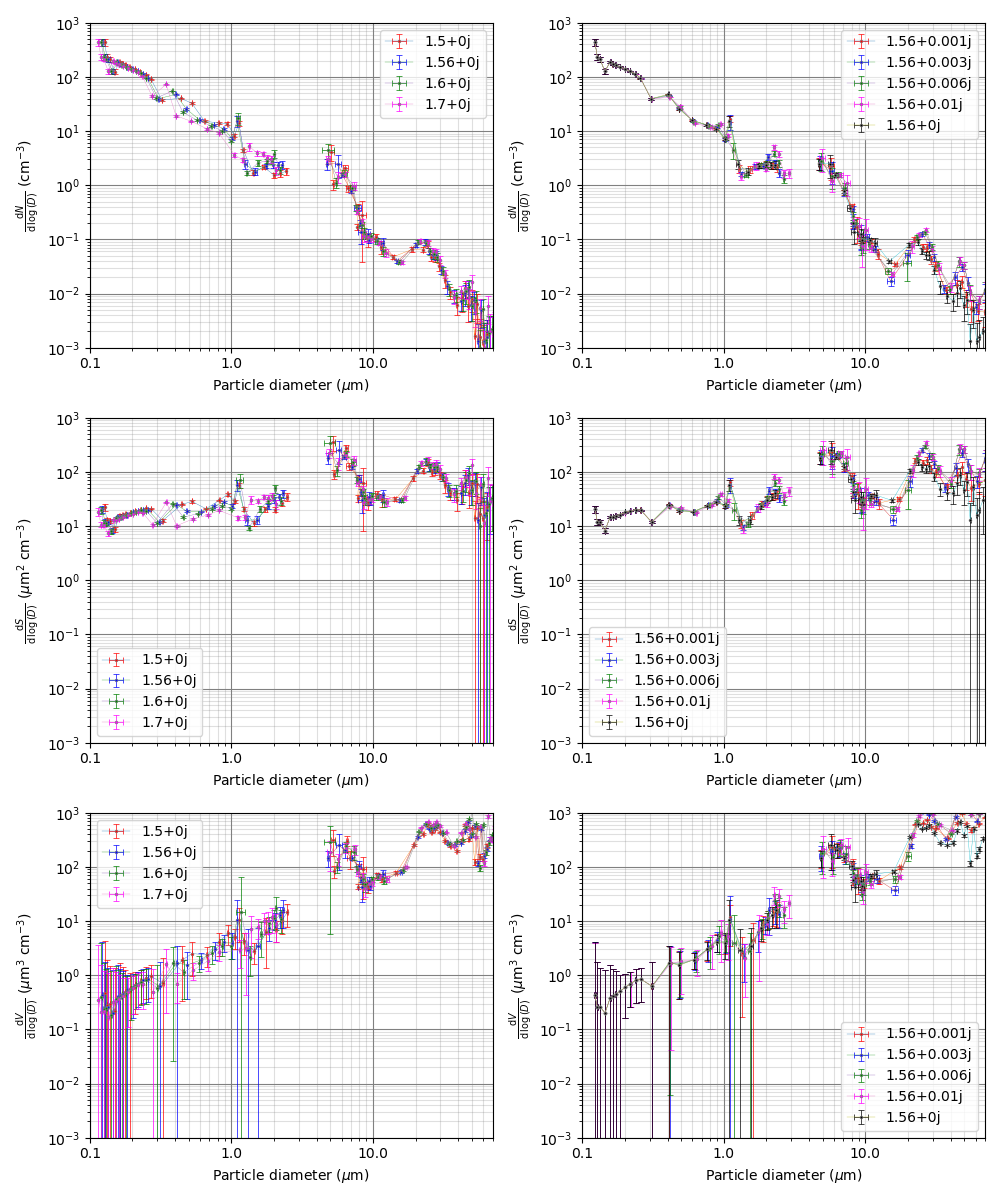

In [30]:
ri_list = get_refractive_indices(pcasp_channel_data_folder, 'PCASP')

kwargs = dict(linewidth=0.25,marker='o',elinewidth=0.5,markersize=2,capsize=2,
            markeredgecolor='gray',markeredgewidth=0.5,capthick=0.25,xlim=[0.1,70],ylim=[1e-3,1e3])

fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10,12))

colors = iter(['r', 'b', 'g', 'magenta'])
for ri in ri_list:
    if ri.imag == 0:
        new_color = next(colors)
        kwargs['ecolor']=new_color
        kwargs['markerfacecolor']=new_color
        kwargs['label'] = str(ri)[1:-1]
        pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = ri)
        pcasp_psds = get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp,
            corrected_pcasp, pcasp_flow, bin_merging=True)
        cdp_cal_at_ri = cdp_calibration.sel(refractive_index = ri)
        cdp_psds = get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)
        # Slicing between 2 and 29 (inclusive) removes first and last bins
        plot_dNdlogD(ax1, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        plot_dSdlogD(ax2, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        plot_dVdlogD(ax3, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        kwargs.pop('label',None)
        plot_dNdlogD(ax1, cdp_psds, False, **kwargs)
        plot_dSdlogD(ax2, cdp_psds, False, **kwargs)
        plot_dVdlogD(ax3, cdp_psds, False, **kwargs)

colors = iter(['r', 'b', 'g', 'magenta', 'k'])
for ri in ri_list:
    if ri.real == 1.56:
        new_color = next(colors)
        kwargs['ecolor']=new_color
        kwargs['markerfacecolor']=new_color
        kwargs['label'] = str(ri)[1:-1]
        pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = ri)
        pcasp_psds = get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp,
            corrected_pcasp, pcasp_flow, bin_merging=True)
        cdp_cal_at_ri = cdp_calibration.sel(refractive_index = ri)
        cdp_psds = get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)
        # Slicing between 2 and 29 (inclusive) removes first and last bins
        plot_dNdlogD(ax4, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        plot_dSdlogD(ax5, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        plot_dVdlogD(ax6, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        kwargs.pop('label',None)
        plot_dNdlogD(ax4, cdp_psds, False, **kwargs)
        plot_dSdlogD(ax5, cdp_psds, False, **kwargs)
        plot_dVdlogD(ax6, cdp_psds, False, **kwargs)
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.legend()
fig.tight_layout()

### Example - Plot total PCASP number concentration over time - flight c274, run 3

Concentration is calculated by adding up all channels. Error is not calculated since it would be messy to display but would be simple to calculate - you simply divide the concentration in each channel by the flow rate and duration (which is 1s so nothing to do). Sum these errors and square root to add these in quadrature since the Poisson error is a square root anyway.

This plot shows the periods where the filter was shut and can optionally display a data flag for the instrument. Check the metadata for full details of the data flag, but in short - 0 or 1, you're fine to use it, 2 or 3, you're not.

<class 'matplotlib.patches.Polygon'>


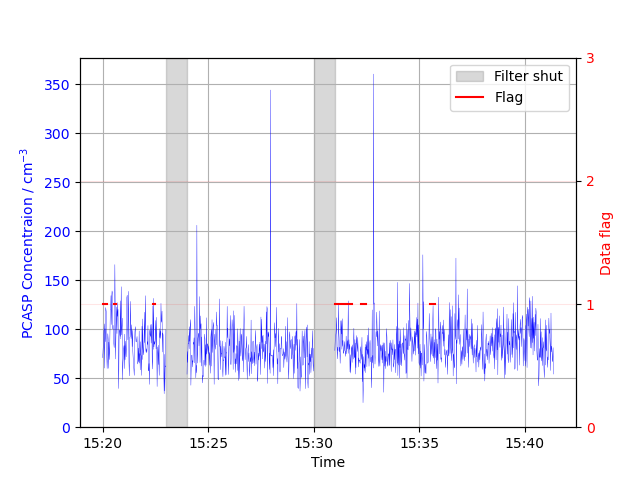

In [31]:
def plot_total_number_concentration(ax, corrected_psd, flag=None, **kwargs):
    """Plot total number concentrations for either the PCASP or CDP probe.
    
    Kwargs implemented for number concentration axis only, not the flag axis,
    which has a fixed display.
    
    Parameters
    ----------
    axes: list of matplotlib axes
        Must have length 3 - first axes for dN/dD plot, second for dS/dD, third for dV/dD
    corrected_psd: xarray DataArray
        particle size distribution corrected for T and P
    flag: xarray DataArray
        data flag for the plot. 
    
    Returns
    -------
    matplotlib axes
        axes plotted on
    """
    dN = corrected_psd.sum(dim='bin')

    indices_of_gaps = list(np.where(np.diff(dN.time) != 1)[0] + 1)
    plot_indices = [i for s in [[0], indices_of_gaps, [-1]] for i in s]

    x_axis_time_fmt = mdates.DateFormatter('%H:%M')
    time = [dt.datetime.fromtimestamp(val) for val in dN.time.values]

    default_kwargs = {
        'xlabel': 'Time',
        'ylabel': r'Concentration / cm$^{-3}$)'
    }
    ax, kwargs = kwarg_handling(ax, default_kwargs, kwargs, ignore_lims=True)
    ax.yaxis.label.set_color('blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.xaxis.set_major_formatter(x_axis_time_fmt)
    ax.grid()
    if len(kwargs) == 0:
        for i in range(len(plot_indices)-1):
            ax.plot(time[plot_indices[i]:plot_indices[i+1]],
                    dN[plot_indices[i]:plot_indices[i+1]], lw=0.25, color='b')
    else:
        for i in range(len(plot_indices)-1):
            ax.plot(time[plot_indices[i]:plot_indices[i+1]],
                    dN[plot_indices[i]:plot_indices[i+1]], **kwargs)        
    label = True
    vspan = None
    if len(indices_of_gaps) > 0:
        for i in indices_of_gaps:
            if label:
                vspan = ax.axvspan(time[i-1],time[i],color='gray',alpha=0.3, label='Filter shut')
                label = False
            else:
                ax.axvspan(time[i-1],time[i],color='gray',alpha=0.3)
    ax.set_ylim(0, None)
    flag_line = None
    if flag is not None:
        flag_ax = ax.twinx()
        flag_time = [dt.datetime.fromtimestamp(val) for val in flag.time.values]
        flag_ax.set_ylim(0,3)
        flag_ax.set_yticks([0,1,2,3])
        flag_ax.tick_params(axis='y', labelcolor='red')
        flag_ax.set_ylabel('Data flag', color='r')
        indices_of_gaps = list(np.where(np.diff(flag.time) != 1)[0] + 1)
        plot_indices = [i for s in [[0], indices_of_gaps, [-1]] for i in s]
        flag_mask = np.where(flag > 0.5, False, True)
        masked_flag= np.ma.masked_where(flag_mask, flag)
        label = True
        for i in range(len(plot_indices)-1):
            if label == True:
                flag_line, = flag_ax.plot(flag_time[plot_indices[i]:plot_indices[i+1]],
                                masked_flag[plot_indices[i]:plot_indices[i+1]],
                                lw=1.5, color='r', label='Flag')
                label = False
            else:
                flag_ax.plot(flag_time[plot_indices[i]:plot_indices[i+1]],
                    masked_flag[plot_indices[i]:plot_indices[i+1]], lw=1.5, color='r')
        flag_ax.grid(visible=True, which='major', color='r', alpha=0.1)
    
    legend_items = []
    if type(vspan) != None:
        print(type(vspan))
        legend_items.append(vspan)
    if flag_line is not None:
        legend_items.append(flag_line)
    ax.legend(legend_items, [l.get_label() for l in legend_items])
    return ax

flag = time_slice_data(run_start_times,run_end_times,flight_data['pcasp_flag'])
fig, ax = plt.subplots()
ax = plot_total_number_concentration(ax, corrected_pcasp.sel(bin=slice(2,29)),flag)

### Example - Comparing CDP data with different humidity caps
The CDP - Cloud Droplet Probe - is unsurprisingly designed to measure cloud droplets. We use it to measure aerosol and use the refractive index correction to adjust the channel diameters accordingly. However, large liquid droplets can significantly bias the size distributions, especially in surface area/volume. One way of reducing the likelihood of  droplets being considered is to remove all data points with relative humidity above a certain threshold. Ben Murray suggests an 80% threshold - but by coincidence, in the example here there aren't actually any times where we measured above 80%!

In [32]:
def mask_humidity_above_threshold(psd, rh_data, rh_threshold):
    """Applies a mask to remove datapoints where relative humidity is above a threshold.

    Parameters
    ----------
    psd: xarray DataArray
        DataArray containing the particle size distribution counts from the FAAM data. Must have
        time dimension, i.e. not yet averaged out.
    rh_data: xarray DataArray
        DataArray containing relative humidity vs time data.
    rh_threshold: float
        Minimum relative humidity to exclude
    """
    rh_mask = rh_data < rh_threshold
    rh_corrected = psd.where(rh_mask,drop=True)
    return rh_corrected

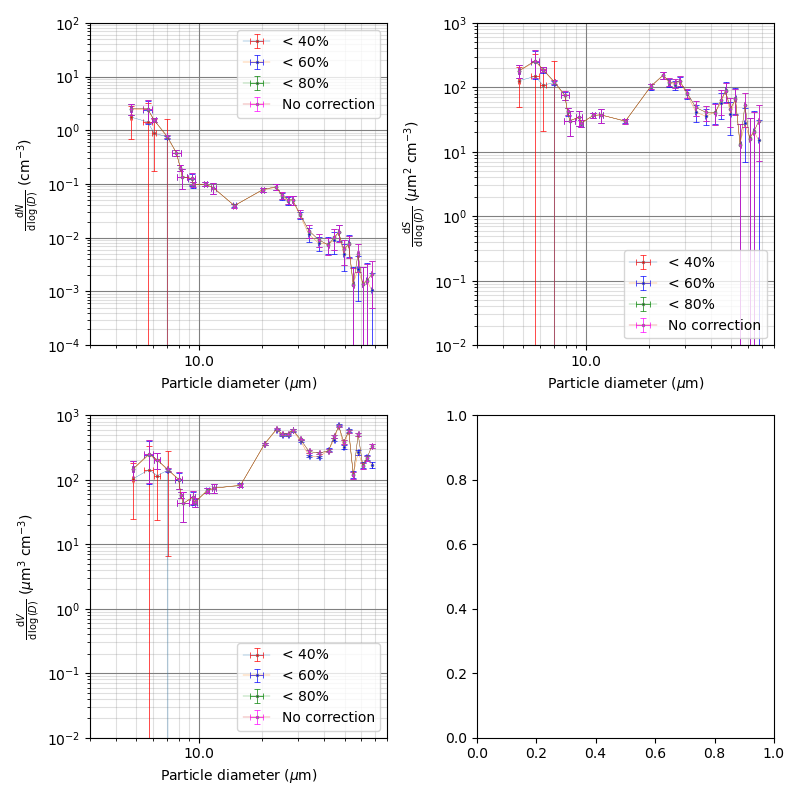

In [33]:
rh_fig, ((rh_ax1, rh_ax2), (rh_ax3, rh_ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

kwargs = dict(linewidth=0.25,marker='o',elinewidth=0.5,markersize=2,capsize=2,
            markeredgecolor='gray',markeredgewidth=0.5,capthick=0.25,xlim=[3,80])

colors = iter(['r', 'b', 'g', 'magenta', 'k'])
rh_liq = time_slice_data(run_start_times, run_end_times, flight_data['RH_LIQ'])
for rh in [40, 60, 80]:
    rh_uncorrected_cdp = mask_humidity_above_threshold(uncorrected_cdp, rh_liq, rh)

    rh_corrected_cdp = mask_humidity_above_threshold(corrected_cdp, rh_liq, rh)
    rh_cdp_psds = get_mean_log_psds(cdp_cal_at_ri, rh_uncorrected_cdp, rh_corrected_cdp, cdp_flow)
    label = '< ' + str(rh) + '%'
    new_color = next(colors)
    kwargs['ecolor']=new_color
    kwargs['markerfacecolor']=new_color
    kwargs['label'] = label
    
    rh_ax1 = plot_dNdlogD(rh_ax1, rh_cdp_psds, False, **kwargs)
    rh_ax2 = plot_dSdlogD(rh_ax2, rh_cdp_psds, False, **kwargs)
    rh_ax3 = plot_dVdlogD(rh_ax3, rh_cdp_psds, False, **kwargs)

new_color = next(colors)
kwargs['ecolor']=new_color
kwargs['markerfacecolor']=new_color
kwargs['label'] = 'No correction'
cdp_psds = get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)

rh_ax1 = plot_dNdlogD(rh_ax1, cdp_psds, True, **kwargs)
rh_ax2 = plot_dSdlogD(rh_ax2, cdp_psds, True, **kwargs)
rh_ax3 = plot_dVdlogD(rh_ax3, cdp_psds, True, **kwargs)
rh_ax1.set_ylim(0.0001,100)
rh_fig.tight_layout()
# Apologies for the laziness not getting rid of that fourth empty box!

### Example - Combining PCASP and CDP data to get a total number/size/volume concentration

In [34]:
def area_under_gap(pcasp_psd, cdp_psd, dist_str):
    """Integrate the area between the last PCASP bin and the first CDP bin.

    Parameters
    ----------
    pcasp_psd: xarray Dataset
        logarithmic particle size distributions for the PCASP
    cdp_psd: xarray Dataset
        logarithmic particle size distribution for the CDP
    dist_str: string
        string specifying the distribution to integrate. Must be dNdlogD, dSdlogD or dVdlogD

    Returns
    -------
    float
        area under the "gap"
    """

    log_max_pcasp_diam = np.log10(pcasp_psd['lin_log_diameter'][-1]) + pcasp_psd['diameter_log_width'][-1]/2
    log_min_cdp_diam = np.log10(cdp_psd['lin_log_diameter'][0]) -  cdp_psd['diameter_log_width'][0]/2
    log_gap_width = log_min_cdp_diam - log_max_pcasp_diam
    a_under_gap = 0.5*(pcasp_psd[dist_str][-1]+cdp_psd[dist_str][0])*log_gap_width
    return a_under_gap.values

def integrate_distribution(pcasp_psd, cdp_psd, dist_str):
    """Integrate a distribution.

    Parameters
    ----------
    pcasp_psd: xarray Dataset
        logarithmic particle size distributions for the PCASP
    cdp_psd: xarray Dataset
        logarithmic particle size distribution for the CDP
    dist_str: string
        string specifying the distribution to integrate. Must be dNdlogD, dSdlogD or dVdlogD

    Returns
    -------
    float
        total integration sum
    """
    pcasp_dX = pcasp_psd[dist_str]*pcasp_psd['diameter_log_width']
    cdp_dX = cdp_psd[dist_str]*cdp_psd['diameter_log_width']
    gap_area = area_under_gap(pcasp_psd, cdp_psds, dist_str)
    total = pcasp_dX.sum(dim='bin').values + cdp_dX.sum(dim='bin').values + gap_area
    return total

units = ['cm-3', 'um2 cm-3', 'um3 cm-3']
for i, dist in enumerate(['dNdlogD', 'dSdlogD', 'dVdlogD']):
    total = integrate_distribution(pcasp_psds.sel(bin=slice(2,29)), cdp_psds, dist)
    print(dist, total, units[i])


dNdlogD 73.02485734281774 cm-3
dSdlogD 151.94755233346532 um2 cm-3
dVdlogD 324.1510836330428 um3 cm-3


# Optional: reading input filter data and metadata
Here, you will need to read your own files. A cell has been left intentionally blank for you to do so.
Examples of the *filters_data* and *filters_metadata* CSVs are included on the Github page if you wish to follow the same layout. *Editor's note - I wouldn't follow the same metadata format, I hate it but I've started so I'll finish...*

In [35]:
# Erin's filter data and metadata
filters_metadata = pd.read_csv(r'..\filters\filters_data.csv', index_col='unique_ID')
filters_metadata = filters_metadata[(filters_metadata['material']=='Teflon') & 
                  (filters_metadata['INP_run_ID']!='Blank') & 
                  (filters_metadata['ignore'] == False)]
filters_data = pd.read_csv(r'..\filters\subtracted_backgrounds_v3.csv',index_col='temp_bin')

In [33]:
# This cell is left intentionally blank for you to read in your own filter data and metadata
# filters_data = 
# filters_metadata = 

## Plotting INP concentrations
If you have chosen to load in INP data, you can use the following function to plot it. Also displayed is an example of the use of `kwargs` as previously mentioned.

In [36]:
def inp_plot(ax, filters_data, highlight_filter_ID=None, connect=False, **kwargs):
    """ Plot all INP concentrations of a campaign on a given axis

    Optionally you may highlight a particular INP concentration curve. NOT compatible with
    matplotlib kwargs option due to specific choices to produce the labelling of a single run.

    Parameters
    ----------
    ax: matplotlib axes
        axes to plot on
    filters_data: pandas dataframe
        dataframe containing background-subtracted data
    highlight_filter_id: string, optional
        string containing unique ID of a INP run. All are in the format described above.
    connect: bool, optional
        choose whether or not to 'connect' the lines. Off by default.
    Returns
    -------
    matplotlib axes
        axes with INP plot

    """
    if connect:
        lw = 1.5
        slw = 0.75
    else:
        lw = slw = 0
    temps = filters_data.index
    if highlight_filter_ID != None:
        # Plot specific filter if wanted
        Nt = filters_data[highlight_filter_ID + '_NT']
        Nt_err = filters_data[highlight_filter_ID + '_err']
        Nt_mask = np.isfinite(Nt)

        ax.errorbar(temps[Nt_mask], Nt[Nt_mask], yerr=Nt_err[Nt_mask], marker='o', markersize=4,
                color='red', capsize=2, elinewidth=1.25, linewidth=lw, zorder=3, label=highlight_filter_ID)

    data = filters_data[filters_data.columns[pd.Series(
        filters_data.columns).str.endswith('NT')]]

    first = True
    for column in data:
        mask = np.isfinite(data[column])
        if first:
            # Cheeky workaround to add legend label to just one of the plots
            ax.plot(temps[mask], data[column][mask], marker='o',
                markersize=2, color='lightgray', linewidth=slw, zorder=1, label='All data')
            first = False
        else:
            ax.plot(temps[mask], data[column][mask], marker='o',
                markersize=2, color='lightgray', linewidth=slw, zorder=1)

    ax.set_yscale('log')

    default_kwargs = {
        'xlim': [-35,0],
        'ylim': [12**-2,10**2],
        'xlabel': 'Temperature / \u00b0C',
        'ylabel': 'INP concentration / L\u207b\u00b9'
    }

    ax, kwargs = kwarg_handling(ax, default_kwargs, kwargs)

    ax.grid()
    ax.legend()
    return ax

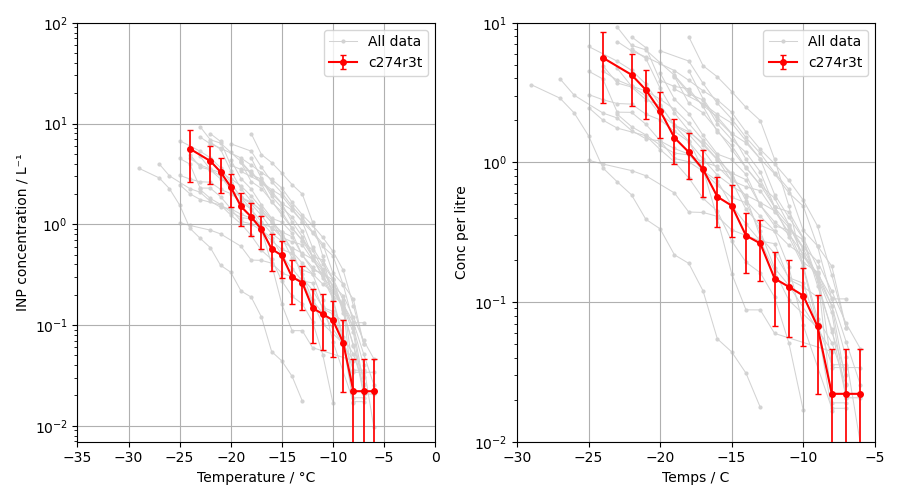

In [37]:
# Plot of INP concentrations - the left uses default plotting options.
inp_only_fig, (standard_inp_ax, custom_inp_ax) = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
kwargs_example = {'xlim':[-30,-5],'ylim':[0.01,10],'xlabel':'Temps / C', 'ylabel':'Conc per litre'}
standard_inp_ax = inp_plot(standard_inp_ax, filters_data, 'c274r3t', True)
custom_inp_ax = inp_plot(custom_inp_ax, filters_data, 'c274r3t', True, **kwargs_example)
inp_only_fig.tight_layout()

# Development aids that I don't want to lose - please ignore

In [60]:
def plot_rh_comparison(ax, psd_to_compare, rh_data, rh_to_choose):
    no_rh_correction = psd_to_compare.mean(dim='time',skipna=True)
    ax.plot(psd_to_compare['bin'], no_rh_correction, lw=0, marker='.', label='No correction')
    print('No Correction, N(CDP) = ', no_rh_correction.sum(dim='bin').values)
    for rh in rh_to_choose:
        rh_mask = rh_data < rh
        rh_corrected = psd_to_compare.where(rh_mask,drop=True)
        rh_corrected_avg = rh_corrected.mean(dim='time', skipna=True)
        rh_str = str(rh)
        rh_label = 'RH < ' + rh_str + '%'
        ax.plot(rh_corrected_avg['bin'], rh_corrected_avg, lw=0, marker='.', label=rh_label)
        print(rh_label + ',', 'N(CDP) = ', rh_corrected_avg.sum(dim='bin').values)
    ax.legend()
    ax.set_xlim(0, 31)
    ax.set_ylim(0.01, 1000)
    ax.set_xlabel('Bin number')
    ax.set_ylabel('Average CDP concentration')
    ax.set_yscale('log')
    ax.grid(visible=True, which='major', color='gray')
    ax.grid(visible=True, which='minor', color='gray', alpha=0.25)
    return ax



No Correction, N(CDP) =  464.23233
RH < 40%, N(CDP) =  271.89688
RH < 60%, N(CDP) =  458.24063


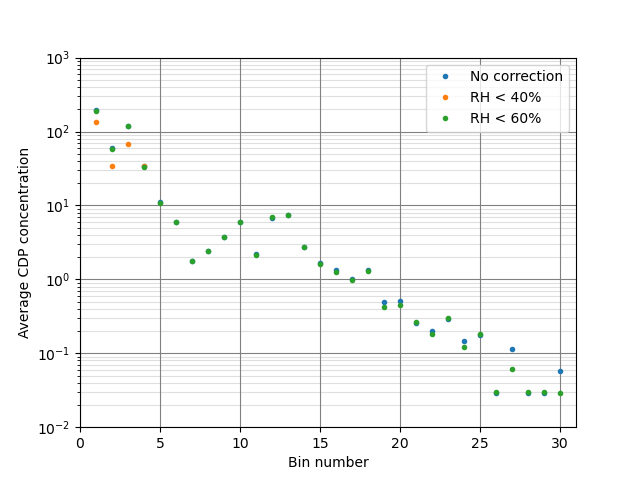

In [61]:
basic_cdp_conc = time_slice_data(run_start_times, run_end_times, flight_data['cdp_conc_psd'])
bin_array = np.arange(1, 31, dtype=float)
basic_cdp_conc = basic_cdp_conc.rename({'cdp_bin_centre': 'bin'})
basic_cdp_conc.coords['bin'] = ('bin', bin_array)
rh_liq = time_slice_data(run_start_times, run_end_times, flight_data['RH_LIQ'])
fig, ax = plt.subplots()
ax = plot_rh_comparison(ax, basic_cdp_conc, rh_liq, [40, 60])

In [27]:
nev_data = xr.open_dataset(r'C:\Users\eeenr\OneDrive - University of Leeds\Kiruna\flights\c274\c274_clear_flag_20220321_r1_nevpower.nc',
engine='netcdf4',decode_times=False)

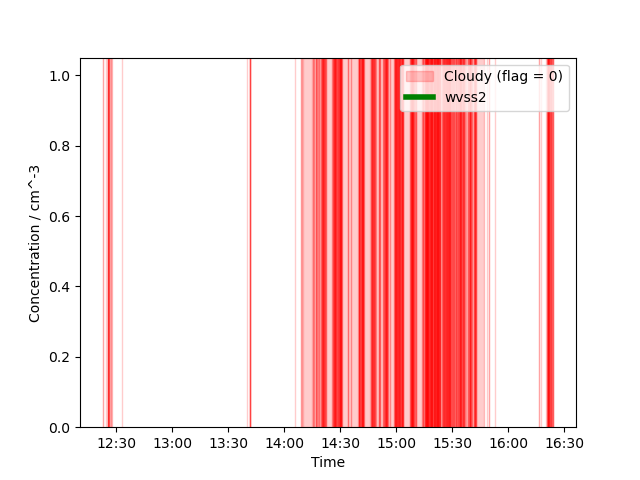

In [98]:
fig, ax = plt.subplots()
x_axis_time_fmt = mdates.DateFormatter('%H:%M')
time = [dt.datetime.fromtimestamp(int(val)) for val in nev_data.TIME.values]
ax.xaxis.set_major_formatter(x_axis_time_fmt)
#ax.plot(time,nev_data.CLRFLG_COMBINED,color='red',alpha=0.2)
#ax2 = ax.twinx()
time = [dt.datetime.fromtimestamp(int(val)) for val in flight_data.time.values]
#ax.plot(time, flight_data.cdp_conc/1000,zorder=2,label='Raw CDP Conc')


time = [dt.datetime.fromtimestamp(int(val)) for val in nev_data.TIME.values]
ax.fill_between(time, 0, 1, where=nev_data.CLRFLG_COMBINED < 0.5,
    transform=ax.get_xaxis_transform(), color='red', alpha = 0.2, zorder=1, label='Cloudy (flag = 0)')
ax.set_ylim(0,None)
ax.set_ylabel('Concentration / cm^-3')
ax.set_xlabel('Time')



wvss2 = time_slice_data(run_start_times, run_end_times, flight_data['WVSS2R_VMR_U'])
time = [dt.datetime.fromtimestamp(int(val)) for val in wvss2.time.values]
ax.plot(time, wvss2,zorder=3,color='g',lw=4,label='wvss2')
ax.legend()